# Form factor to total density prediction model training
This notebook shows how a deep learning model can be trained to predict total density profiles from form factors.  
The notebook contains the following steps: 
1) Download the data using the [NMR lipids API](https://nmrlipids.github.io/databankLibrary.html).  
2) Preprocess data for the machine learning pipeline.  
3) Training and evaluating the performance of the neural network.  

Variable descriptions from the [NMRlipids databank](https://nmrlipids.github.io/listOfFiles.html#):  
* Total densities: Total electron densities calculated with calc_FormFactors.py and stored in /Data/Simulations for all simulations. X-axis units are nm and y-axis units e/nm3.  
* Form factors: X-ray scattering calculated with calc_FormFactors.py and stored in /Data/Simulations for all simulations. X-axis value unit are Å-1 and y-axis value units are e/nm2.  

### Load the required libraries
Create a virtual environment using e.g. Poetry, and install the following libraries that will be needed. 
The code block below loads the required libraries if they are available in the virtual environment. If errors are generated, check the available libraries e.g. using pip list and install whichever libraries are missing.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.python.keras.callbacks import EarlyStopping

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = (
    "3"  # Set TensorFlow verbosity to lowest (only print errors)
)

### Initialize a random number generator
This will be used to split the data into training and test sets reproducibly. 

In [2]:
seed = 43715679334954349782040625626900603510
rng = np.random.default_rng(seed)

### Download and initialize the NMR lipids databank
To access the NMR lipids databank, clone the NMRlipids databank git repository into your working folder as explained at https://nmrlipids.github.io/databankLibrary.html: 
```
git clone https://github.com/NMRLipids/Databank.git
```
After doing so, the following code block sets up the databank for use.

In [3]:
# Initialize the NMR lipids databank
databankPath = "./Databank/"  # this is the local path for the cloned Databank
sys.path.insert(1, databankPath + "/Scripts/BuildDatabank/")
from databankLibrary import *
from new_functions import *

systems = initialize_databank(databankPath)

Databank initialized from the folder: /Users/even/NMRlipids/Databank/Data/Simulations


In [4]:
# Some systems have periodic boundary condition (PBC) warnings and should be excluded from the analysis
PBC_warning_count = 0
xnormal_warning_count = 0
for system in systems:
    if "WARNINGS" in system.keys() and type(system["WARNINGS"]) == dict:
        if "PBC" in system["WARNINGS"].keys():
            PBC_warning_count += 1
            # print("System ", system["ID"], ": ", system["WARNINGS"], sep="")
        if "ORIENTATION" in system["WARNINGS"].keys() and system["WARNINGS"]["ORIENTATION"] == "x-normal":
            xnormal_warning_count += 1
            # print("System ", system["ID"], ": ", system["WARNINGS"], sep="")
print("Number of systems with PBC warnings:", PBC_warning_count)
print("Number of systems with xnormal warnings:", xnormal_warning_count)

Number of systems with PBC warnings: 15
Number of systems with xnormal warnings: 3


With the databank initiated, the form factor (ff) and total density (td) data of each simulation can be extracted from the "system" variables.  
Each form factor has a shape of (1000), but the total densities have dimensions that vary.  
The total densities are split into separate lists td_x and td_y.  

In [5]:
system_ids = []
all_ff = []
all_td_x = []
all_td_y = []
td_x_lengths = []
td_y_lengths = []

# Complete data should have form factors of length 1000
required_form_factor_dimension = 1000

# Load form factors and total densities
for system in systems:
    if "WARNINGS" in system.keys() and type(system["WARNINGS"]) == dict:
        if "PBC" in system["WARNINGS"].keys():
            continue # Skip system with PBC warnings
        elif "ORIENTATION" in system["WARNINGS"].keys() and system["WARNINGS"]["ORIENTATION"] == "x-normal":
            continue # Skip system with x-normal orientation warnings
    FFsim, TDsim = getFormFactorAndTotalDensityPair(system, databankPath)
    if (
        isinstance(FFsim, list)
        and isinstance(TDsim, list)
        and len(FFsim) == required_form_factor_dimension
    ):
        system_ids.append(system["ID"]) # Add system ID to the list

        ff = np.array([elem[1] for elem in FFsim])
        all_ff.append(ff) # Add form factor to the list

        td_x = np.array([elem[0] for elem in TDsim])
        td_y = np.array([elem[1] for elem in TDsim])
        all_td_x.append(td_x) # Add total density x values to the list
        all_td_y.append(td_y) # Add total density y values to the list
        td_x_lengths.append(len(td_x))
        td_y_lengths.append(len(td_y))

del systems
assert len(system_ids) == len(all_ff) == len(all_td_x) == len(all_td_y) # Be sure that there are as many form factors as total densitiess
assert td_x_lengths == td_y_lengths # Be sure that dimensions of x and y values match for every simulation
N_experiments = len(all_ff)
print("Number of form factor and total density pairs:", N_experiments)

Number of form factor and total density pairs: 774


In [6]:
# Sort all lists by system id
system_ids, all_ff, all_td_x, all_td_y, td_x_lengths, td_y_lengths = [list(elem) for elem in zip(*sorted(zip(system_ids, all_ff, all_td_x, all_td_y, td_x_lengths, td_y_lengths)))]
print(system_ids)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,

### Take the time to get to know what the data looks like

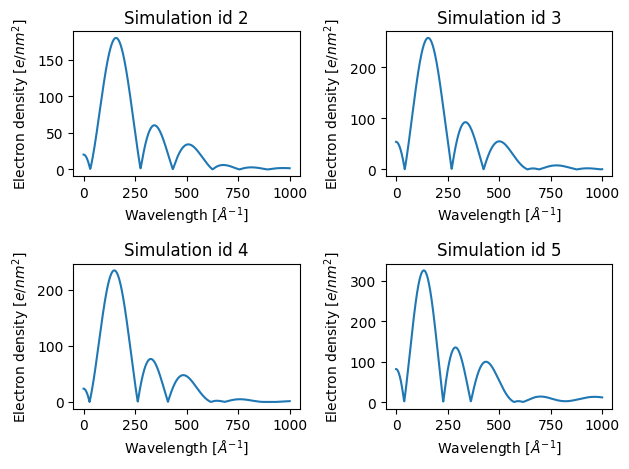

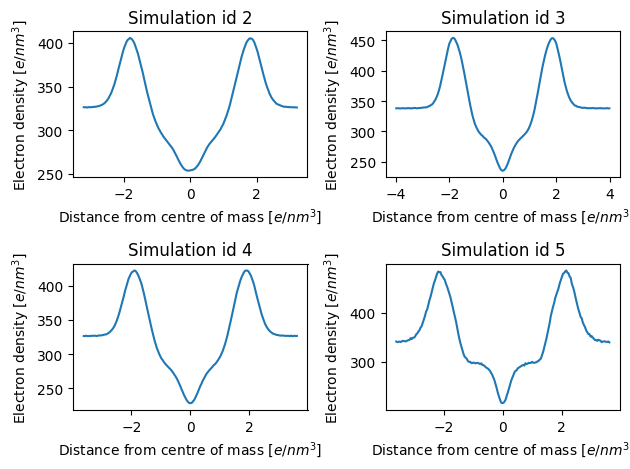

In [7]:
# Visualize form factors and total density profiles
# Rerun this block to cycle through different simulations, or use the line below to reset the plot counter
# start_of_plotting = 0 

if 'start_of_plotting' not in globals():
    start_of_plotting = 0

# Plot four density profiles
ff_fig, ff_axs = plt.subplots(nrows=2, ncols=2)
#plt.suptitle("Form factors of simulations " + str(start_of_plotting) + " to " + str(start_of_plotting+3))
ff_axs = ff_axs.flatten()

td_fig, td_axs = plt.subplots(nrows=2, ncols=2)
#plt.suptitle("Density profiles of simulations " + str(start_of_plotting) + " to " + str(start_of_plotting+3))
td_axs = td_axs.flatten()

# ff_xvalues = np.linspace(0,)

plot_index = 0
for plot_counter, (system_id, x_vector, y_vector, ff_vector) in enumerate(zip(system_ids, all_td_x, all_td_y, all_ff)):
    if plot_counter >= start_of_plotting:
        ff_axs[plot_index].plot(ff_vector)
        ff_axs[plot_index].set_title("Simulation id " + str(system_id))
        ff_axs[plot_index].set_xlabel("Wavelength ["+r'$Å^{-1}$'+"]")
        ff_axs[plot_index].set_ylabel("Electron density ["+r'$e/nm^2$'+"]")
        td_axs[plot_index].plot(x_vector, y_vector)
        td_axs[plot_index].set_xlabel("Distance from centre of mass ["+r'$e/nm^3$'+"]")
        td_axs[plot_index].set_ylabel("Electron density ["+r'$e/nm^3$'+"]")
        td_axs[plot_index].set_title("Simulation id " + str(system_id))
        plot_index += 1
        if plot_index >= 4:
            start_of_plotting = plot_counter + 1
            break
ff_fig.tight_layout()
td_fig.tight_layout()

Looking through the simulations reveals the following facts about the data: 
- Some total densities are more smooth than others. 
- The x axis range of the total densities varies between simulations.
- Most density profiles have flat "shoulders", but not all: Some seem to be truncated in the x direction.

In [8]:
# Find the systems with narrow x dimension
narrow_limit = 2.9 # Many systems whose total density profiles are narrower than [-2.9, 2.9] seem to have nonsmooth periodic conditions that are not marked by errors
narrow_td_systems = []
for system_id, x_vector, y_vector, ff_vector in zip(system_ids, all_td_x, all_td_y, all_ff):
    if max(x_vector) < narrow_limit:
        narrow_td_systems.append(system_id)
print("IDs of systems with narrow total densities:", narrow_td_systems)
print("Number of systems with narrow total densities:", len(narrow_td_systems))

IDs of systems with narrow total densities: [81, 94, 101, 124, 128, 277, 289, 344, 375, 378, 379, 477, 519, 582, 606, 614, 755, 756, 795, 796, 798, 799, 800, 802, 803, 804, 806, 807, 809, 810, 811, 812, 815, 816, 817, 818, 819]
Number of systems with narrow total densities: 37


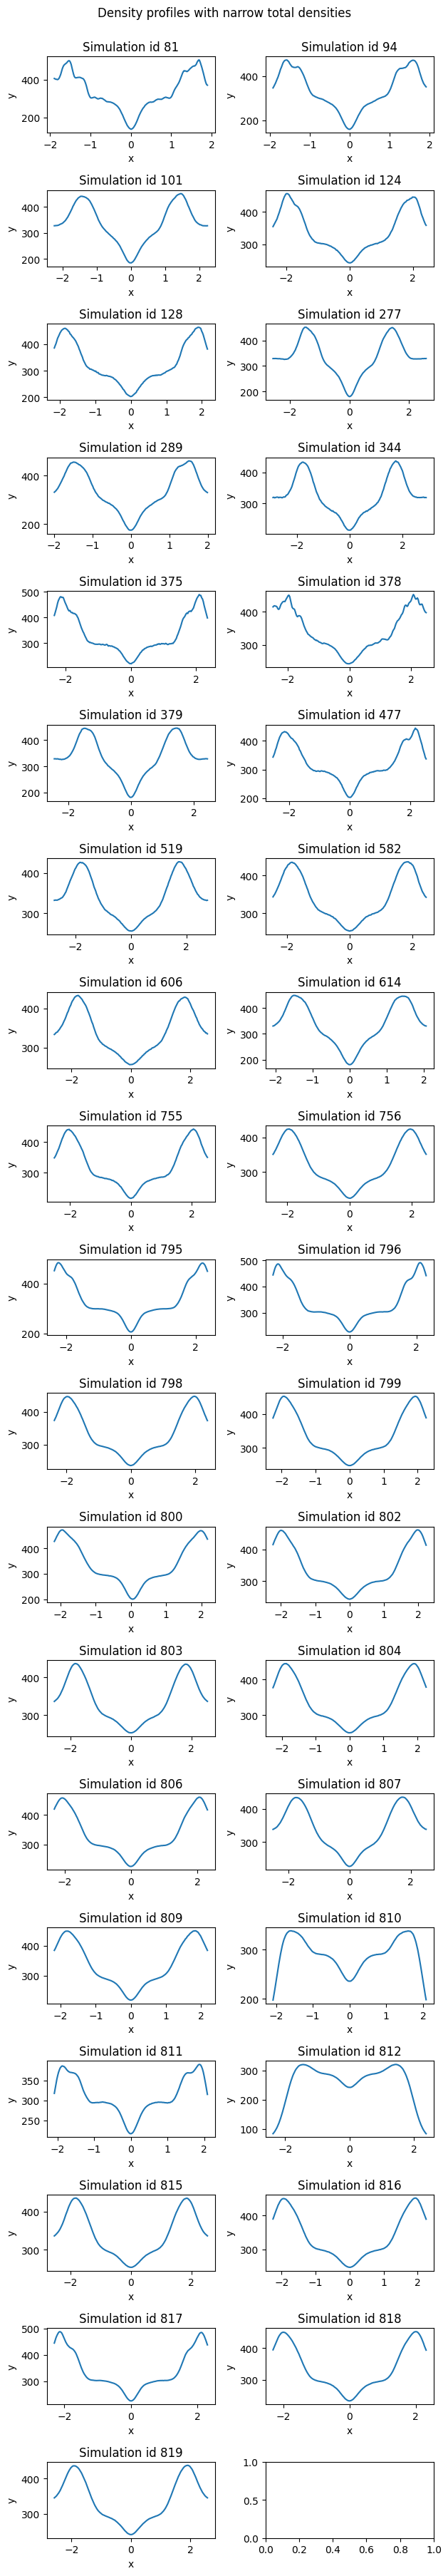

In [9]:
# Plot density profiles with nonsmooth boundaries
figrows = int(np.ceil(len(narrow_td_systems)/2))
pbc_fig, td_axs = plt.subplots(nrows=figrows, ncols=2)
plt.suptitle("Density profiles with narrow total densities")
td_axs = td_axs.flatten()

plot_index = 0
for system_id, x_vector, y_vector, ff_vector in zip(system_ids, all_td_x, all_td_y, all_ff):
    if system_id in narrow_td_systems:
        td_axs[plot_index].plot(x_vector, y_vector)
        td_axs[plot_index].set_xlabel("x")
        td_axs[plot_index].set_ylabel("y")
        td_axs[plot_index].set_title("Simulation id " + str(system_id))
        plot_index += 1
pbc_fig.set_figheight(2*figrows)
pbc_fig.tight_layout(rect=[0, 0.03, 1, 0.98])

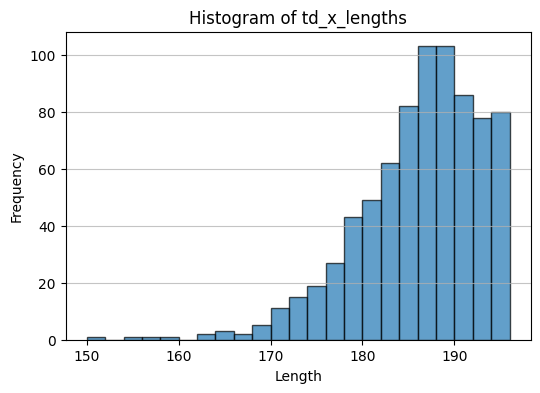

Every td_x length present in the dataset: {150, 154, 156, 158, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196}
(The lenght of td_y matches td_x for each simulation)


In [11]:
# Visualize that the length of the total density data varies between simulations
plt.figure(figsize=(6, 4))
plt.hist(td_x_lengths, bins=23, edgecolor='black', alpha=0.7)
plt.title("Histogram of td_x_lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()
print("Every td_x length present in the dataset:", set(td_x_lengths)) 
print("(The lenght of td_y matches td_x for each simulation)")

Looking through the simulations reveals the following facts about the data: 
- Some total densities are more smooth than others. 
- The x axis range varies between simulations.
- Most density profiles have flat "shoulders", but not all. Some seem to be truncated in the x direction.

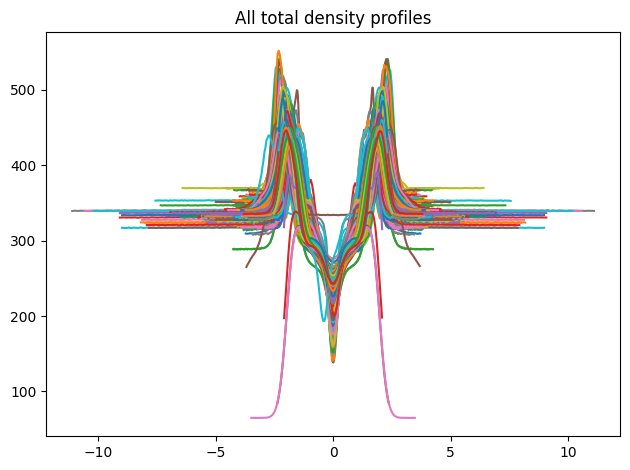

In [12]:
# Plot all total density profiles together
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(ax, all_td_x, all_td_y)
plt.title("All total density profiles")
plt.tight_layout()
plt.show()

### Homogenize the data format of the total densities
The histogram of td_x_lengths shows that the different simulations have different numbers of observed values.  
Furthermore, the plot of total densities shows that some total densities have long flat tails while others are seemingly truncated in the x direction.  
Since the model fitting requires data with a uniform format, a preprocessing process is needed to define a common x grid for the density profiles.  

To select the x interval, one option is to constrict the x range to the most narrow observed experiment, but this leads to a loss of information for the wider experiments.  
Aother option is to only include the widest experiments, but this also leads to a large loss of data.  
A compromise could be to trim the shoulders of the widest simulations, and extrapolate the narrowest simulations a bit. 

In the following code block, an x interval centered around zero is chosen.  
Experiments that are narrower than this interval are extrapolated in the x direction in a simple way: using the y values at the ends of the observation window.  
This makes sure that all experiments have either actual measurements or extrapolated values across the entire x interval.  

Next, a Gaussian Process Regression is used to interpolate (predict values between points) on a uniform set of x coordinates that cover the x interval.  
This brings all the data on the same format. 

In [13]:
# Define start and end of x interval
x_interval_start = - narrow_limit
x_interval_end = narrow_limit
desired_length_of_padded_data = 400

padded_td_x = [
    extrapolate_X(td_x, desired_length_of_padded_data, x_interval_start, x_interval_end)
    for td_x in all_td_x
]
padded_td_y = [extrapolate_Y(td_y, desired_length_of_padded_data) for td_y in all_td_y]

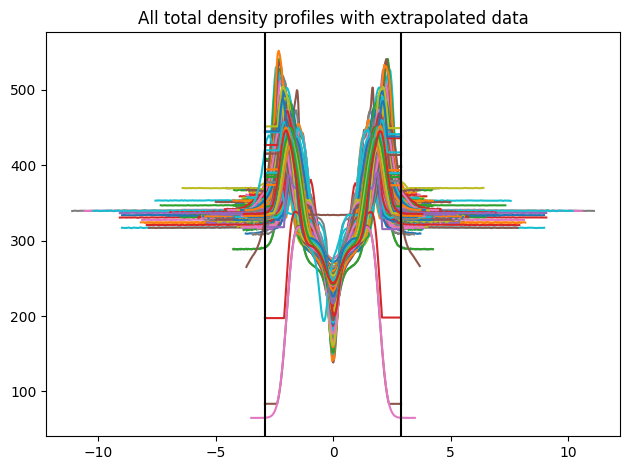

In [14]:
# Plot total density profiles
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, padded_td_x, padded_td_y, lines=[x_interval_start, x_interval_end]
)
plt.title("All total density profiles with extrapolated data")
plt.tight_layout()
plt.show()

A Gaussian Process Regression is used to interpolate (predict values between points) on the uniform set of x coordinates.

In [15]:
# Interpolate with a Gaussian Process Regression to achieve a uniform x grid
uniform_x_range_dimension = 200

# Define the points for prediction
uniform_x_range = np.linspace(x_interval_start, x_interval_end, uniform_x_range_dimension).reshape(-1, 1)

# Interpolate y values on the uniform x grid using Gaussian Process Regression (GPR)
standardized_y = interpolate_with_GPR(
    padded_td_x, padded_td_y, uniform_x_range
)

Gather form factors and total densities in data frames.

In [16]:
# Convert the data to a pandas DataFrame
sim_FF_df = pd.DataFrame(all_ff)
sim_TD_y_df = pd.DataFrame(standardized_y)

Get to know the data at a glance by calling the df name in a code block.

In [17]:
sim_FF_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,20.400095,20.379938,20.319473,20.218725,20.077738,19.896568,19.675291,19.413999,19.112800,18.771819,...,1.827205,1.815026,1.802471,1.789549,1.776272,1.762650,1.748694,1.734414,1.719820,1.704925
1,54.014919,53.982579,53.885573,53.723944,53.497758,53.207113,52.852132,52.432965,51.949792,51.402818,...,0.093850,0.105642,0.141658,0.188558,0.240078,0.293803,0.348705,0.404281,0.460256,0.516460
2,23.701356,23.672345,23.585327,23.440341,23.237453,22.976756,22.658368,22.282435,21.849129,21.358646,...,1.374773,1.390022,1.404857,1.419274,1.433269,1.446836,1.459973,1.472674,1.484937,1.496758
3,81.493066,81.436932,81.268562,80.988049,80.595552,80.091290,79.475545,78.748662,77.911050,76.963175,...,12.098163,12.036020,11.971822,11.905589,11.837342,11.767104,11.694895,11.620740,11.544662,11.466685
4,22.504947,22.483457,22.418994,22.311585,22.161272,21.968114,21.732189,21.453589,21.132426,20.768828,...,1.959845,1.950184,1.939724,1.928476,1.916453,1.903665,1.890123,1.875841,1.860830,1.845102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,365.838000,365.828000,365.798000,365.749000,365.679000,365.589000,365.480000,365.351000,365.202000,365.033000,...,10.235200,10.208500,10.176100,10.138300,10.094800,10.045900,9.991440,9.931550,9.866230,9.795520
770,586.042000,586.016000,585.940000,585.813000,585.634000,585.405000,585.125000,584.795000,584.413000,583.981000,...,11.018900,11.142600,11.265300,11.387100,11.507700,11.627200,11.745300,11.862200,11.977500,12.091400
771,411.839000,411.826000,411.788000,411.724000,411.636000,411.522000,411.382000,411.218000,411.028000,410.812000,...,5.551680,5.388110,5.220630,5.049350,4.874380,4.695820,4.513790,4.328410,4.139800,3.948100
772,100.942000,100.955000,100.993000,101.057000,101.146000,101.261000,101.401000,101.566000,101.756000,101.972000,...,4.188490,4.293360,4.395560,4.495050,4.591760,4.685670,4.776720,4.864870,4.950090,5.032330


In [18]:
sim_TD_y_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,326.708973,326.822051,326.935361,327.116471,327.397192,327.749660,328.129295,328.537490,329.015110,329.623919,...,329.513163,328.990149,328.597918,328.208821,327.769745,327.336125,327.015293,326.851481,326.791227,326.723253
1,339.493960,339.547829,339.818565,340.352144,341.050579,341.755051,342.386615,343.013535,343.806705,344.921229,...,345.091658,343.904690,342.943181,342.138401,341.447977,340.886187,340.471955,340.181947,339.944181,339.676463
2,328.577659,328.801028,329.126330,329.688468,330.528541,331.575497,332.725315,333.937708,335.269565,336.828041,...,336.690003,335.115621,333.785680,332.629419,331.615086,330.733102,329.994266,329.401942,328.948006,328.585553
3,358.739937,361.330278,363.837029,366.470092,369.576829,373.424724,378.102940,383.439654,389.123728,394.861670,...,393.687705,389.094936,384.600616,380.033853,375.464303,371.008993,366.876894,363.191533,360.023498,357.403437
4,325.767664,326.120133,326.695042,327.233264,327.539294,327.628920,327.676287,327.874115,328.310637,328.925483,...,329.729334,329.200399,328.280452,327.339608,326.747053,326.586143,326.656962,326.678788,326.552475,326.357434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,390.032050,390.078155,389.997236,390.053427,390.102303,390.017205,389.969837,390.054820,390.136552,390.072931,...,389.506381,389.551659,389.464180,389.392665,389.452744,389.523563,389.462787,389.425346,389.501273,389.484903
770,444.745224,444.795146,444.905437,444.976256,444.781446,444.801821,444.998895,444.996457,444.788644,444.707841,...,437.908314,438.027197,438.214808,438.169299,437.983080,438.015123,438.199019,438.062258,438.064580,437.359411
771,394.292102,394.312303,394.382425,394.411217,394.301157,394.327627,394.435365,394.415861,394.294192,394.270044,...,393.269061,393.320724,393.461897,393.455280,393.326587,393.327516,393.451681,393.378424,393.360313,392.944224
772,345.507051,345.516397,345.482671,345.506587,345.527019,345.481510,345.468043,345.531431,345.555347,345.453414,...,345.563938,345.669354,345.653100,345.588086,345.596909,345.640562,345.627327,345.598767,345.632667,345.613163


### Plot all form factors and total densities

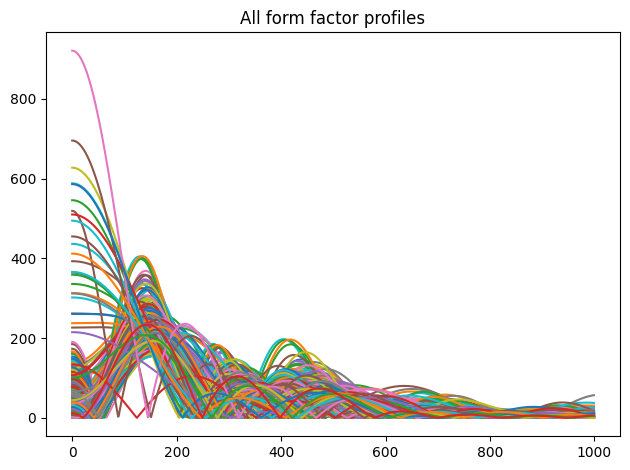

In [19]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, sim_FF_df)
plt.title("All form factor profiles")
plt.tight_layout()
plt.show()

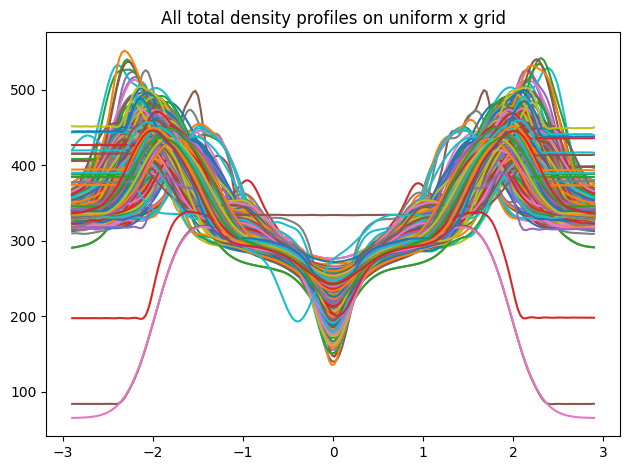

In [20]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(ax, uniform_x_range, sim_TD_y_df)
plt.title("All total density profiles on uniform x grid")
plt.tight_layout()
plt.show()

### Split data into train and test sets

In [68]:
train_input, train_output, test_input, test_output = split_train_and_test(
    sim_FF_df, sim_TD_y_df, system_ids, rng, train_proportion=0.8
)
N_train = train_input.shape[0]
N_test = test_input.shape[0]
print("N_train:", N_train)
print("N_test:", N_test)

N_train: 619
N_test: 155


In [69]:
# Rescale input and output to unit ranges using min and max values of the train set
min_ff_train = train_input.values.min()
max_ff_train = train_input.values.max()
train_input = rescale_to_zero_centered_unit_range(train_input, min_ff_train, max_ff_train)
test_input = rescale_to_zero_centered_unit_range(test_input, min_ff_train, max_ff_train)

# Output
min_td_y_train = train_output.values.min()
max_td_y_train = train_output.values.max()
train_output = rescale_to_zero_centered_unit_range(train_output, min_td_y_train, max_td_y_train)
test_output = rescale_to_zero_centered_unit_range(test_output, min_td_y_train, max_td_y_train)

In [70]:
train_input

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
108,-0.482042,-0.482069,-0.482152,-0.482291,-0.482485,-0.482733,-0.483037,-0.483396,-0.483810,-0.484278,...,-0.494036,-0.494060,-0.494086,-0.494111,-0.494137,-0.494163,-0.494189,-0.494215,-0.494241,-0.494268
180,-0.446499,-0.446525,-0.446604,-0.446735,-0.446918,-0.447153,-0.447441,-0.447780,-0.448172,-0.448615,...,-0.499832,-0.499841,-0.499849,-0.499857,-0.499864,-0.499872,-0.499879,-0.499886,-0.499892,-0.499897
37,-0.451103,-0.451129,-0.451207,-0.451336,-0.451518,-0.451751,-0.452035,-0.452371,-0.452758,-0.453197,...,-0.498463,-0.498460,-0.498458,-0.498458,-0.498458,-0.498460,-0.498462,-0.498466,-0.498471,-0.498477
82,-0.381665,-0.381713,-0.381857,-0.382097,-0.382432,-0.382863,-0.383389,-0.384010,-0.384726,-0.385536,...,-0.496280,-0.496256,-0.496234,-0.496212,-0.496192,-0.496173,-0.496156,-0.496139,-0.496124,-0.496111
739,-0.463230,-0.463271,-0.463396,-0.463605,-0.463896,-0.464271,-0.464728,-0.465268,-0.465890,-0.466593,...,-0.498387,-0.498341,-0.498296,-0.498251,-0.498206,-0.498162,-0.498119,-0.498076,-0.498034,-0.497992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,-0.451664,-0.451701,-0.451810,-0.451993,-0.452248,-0.452575,-0.452975,-0.453447,-0.453991,-0.454606,...,-0.499789,-0.499756,-0.499719,-0.499678,-0.499636,-0.499594,-0.499551,-0.499507,-0.499464,-0.499422
560,-0.417490,-0.417524,-0.417626,-0.417795,-0.418031,-0.418335,-0.418706,-0.419144,-0.419649,-0.420221,...,-0.498986,-0.499037,-0.499088,-0.499140,-0.499192,-0.499244,-0.499297,-0.499349,-0.499402,-0.499456
257,-0.456018,-0.456061,-0.456190,-0.456406,-0.456707,-0.457094,-0.457567,-0.458125,-0.458768,-0.459496,...,-0.495010,-0.495156,-0.495300,-0.495440,-0.495577,-0.495710,-0.495840,-0.495967,-0.496090,-0.496209
253,-0.441144,-0.441173,-0.441259,-0.441403,-0.441604,-0.441862,-0.442177,-0.442550,-0.442979,-0.443465,...,-0.499518,-0.499479,-0.499441,-0.499402,-0.499363,-0.499324,-0.499285,-0.499245,-0.499206,-0.499166


In [71]:
train_output

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
108,0.046973,0.047600,0.048394,0.049501,0.051103,0.053284,0.055972,0.058983,0.062209,0.065702,...,0.066163,0.062279,0.058984,0.056271,0.054087,0.052330,0.050864,0.049579,0.048417,0.047372
180,0.040826,0.041183,0.041709,0.042324,0.042950,0.043558,0.044188,0.044938,0.045934,0.047294,...,0.048283,0.046895,0.045734,0.044742,0.043859,0.043025,0.042226,0.041565,0.041198,0.041194
37,0.035987,0.036520,0.037701,0.038984,0.039716,0.039472,0.038514,0.037671,0.037728,0.038888,...,0.040617,0.039964,0.038652,0.037057,0.036072,0.036301,0.037526,0.038678,0.038827,0.037751
82,0.055220,0.057042,0.059130,0.061592,0.064551,0.068076,0.072183,0.076886,0.082250,0.088428,...,0.087606,0.081335,0.075724,0.070864,0.066840,0.063603,0.060956,0.058678,0.056659,0.054932
739,0.100517,0.103991,0.107248,0.110313,0.113407,0.116713,0.120245,0.123852,0.127409,0.130949,...,0.130815,0.127148,0.123568,0.119983,0.116312,0.112594,0.108958,0.105543,0.102410,0.099507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.021249,0.021549,0.022253,0.023164,0.024053,0.024839,0.025660,0.026789,0.028468,0.030784,...,0.031617,0.029377,0.027716,0.026547,0.025700,0.024996,0.024308,0.023594,0.022880,0.022222
560,0.047785,0.048111,0.048402,0.048770,0.049345,0.050132,0.051027,0.051914,0.052790,0.053857,...,0.054805,0.053050,0.051822,0.050938,0.050225,0.049572,0.048994,0.048551,0.048256,0.048063
257,0.074728,0.078931,0.084011,0.090041,0.097321,0.106198,0.116694,0.128392,0.140668,0.153181,...,0.153025,0.139288,0.126327,0.114576,0.104455,0.096089,0.089193,0.083297,0.078056,0.073507
253,0.044308,0.043933,0.043891,0.044388,0.045068,0.045432,0.045321,0.045186,0.045720,0.047437,...,0.049940,0.049536,0.048292,0.046060,0.043513,0.041775,0.041571,0.042734,0.044324,0.045281


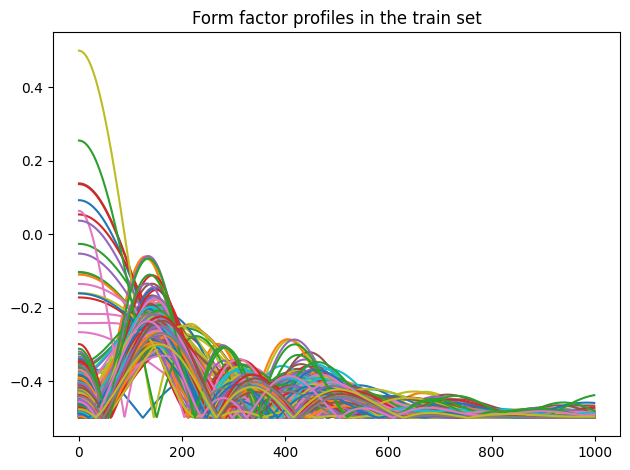

In [72]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, train_input)
plt.title("Form factor profiles in the train set")
plt.tight_layout()
plt.show()

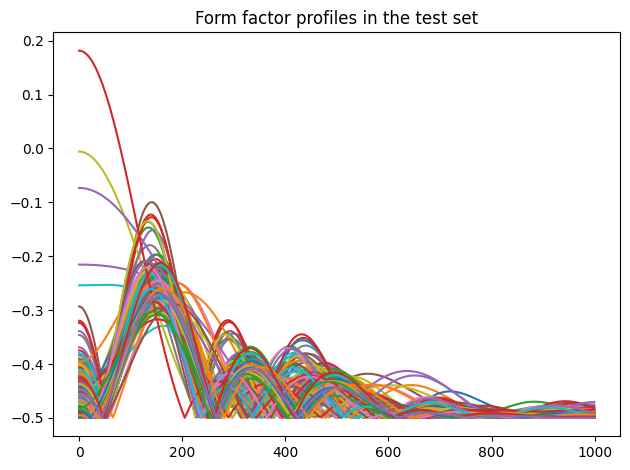

In [73]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, test_input)
plt.title("Form factor profiles in the test set")
plt.tight_layout()
plt.show()

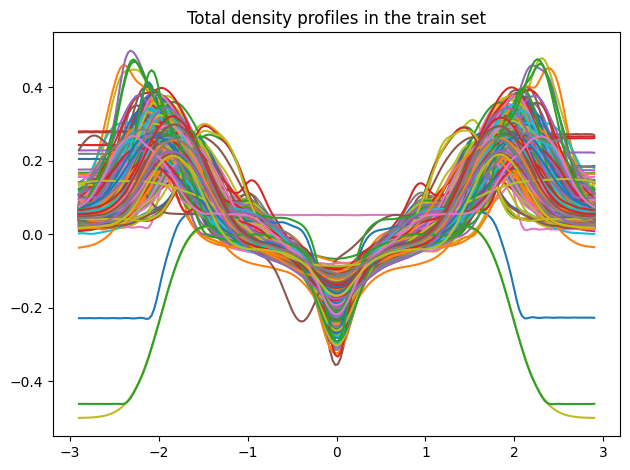

In [74]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(ax, uniform_x_range, train_output)
plt.title("Total density profiles in the train set")
plt.tight_layout()
plt.show()

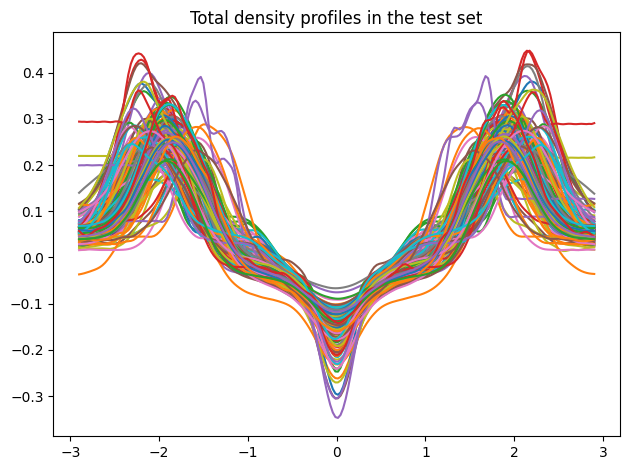

In [75]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(ax, uniform_x_range, test_output)
plt.title("Total density profiles in the test set")
plt.tight_layout()
plt.show()

### Train a neural net

Minimal working solution:

In [76]:
# Adam = tf.keras.optimizers.Adam(amsgrad=True)
# inputs = keras.Input(shape=(required_form_factor_dimension,))
# x = layers.Dense(required_form_factor_dimension, activation="relu")(inputs)
# outputs = layers.Dense(output_dim, activation="linear")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer=Adam, loss="mean_absolute_error")
# history = model.fit(
#     train_input,
#     train_output,
#     batch_size=128,
#     epochs=1500,
#     validation_split=0.2,
#     callbacks=[
#         EarlyStopping(
#             monitor="val_loss", mode="min", patience=100, restore_best_weights=True
#         )
#     ],
#     verbose=0,
# )

In [77]:
def get_fully_connected_model(input_dim: int, hidden_layer_dims: tuple[int, ...], output_dim: int):
    keras_input = keras.Input(shape=(input_dim,))
    for dim in hidden_layer_dims:
        hidden_layer = layers.Dense(dim, activation="relu")(keras_input)
    output_layer = layers.Dense(output_dim, activation="linear")(hidden_layer)
    model = keras.Model(inputs=keras_input, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.AdamW(amsgrad=True), loss="mean_absolute_error")
    return model

In [78]:
baseline_hidden_layers = (1000,)
extended_hidden_layers = (2000, 4000)

model_baseline = get_fully_connected_model(
    input_dim=required_form_factor_dimension, 
    hidden_layer_dims=baseline_hidden_layers, 
    output_dim=uniform_x_range_dimension
    )

model_extended = get_fully_connected_model(
    input_dim=required_form_factor_dimension, 
    hidden_layer_dims=extended_hidden_layers, 
    output_dim=uniform_x_range_dimension
    )

#model_1d_cnn = []

model = model_baseline

general_start_time = time.time()
history = model.fit(
    train_input,
    train_output,
    batch_size=128,
    epochs=1500,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", patience=100, restore_best_weights=True
        )
    ],
    verbose=0,
)

# Time use
general_end_time = time.time()
print("Used time: " + str(general_end_time - general_start_time) + " seconds")

Used time: 31.713709831237793 seconds


In [79]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 200)            │       200,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,804,802 (18.33 MB)

 Trainable params: 1,201,200 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,603,602 (13.75 MB)

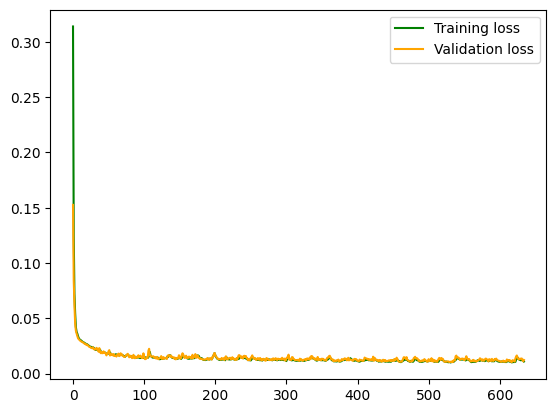

In [80]:
# Plot the training history of the model
fig, ax = plt.subplots()
ax = plot_training_trajectory(ax, history)
plt.show()

# Compare predictions to true test case values

In [90]:
predictions = model.predict(test_input)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [91]:
predictions

array([[0.07551149, 0.07325644, 0.07382573, ..., 0.07392549, 0.07226767,
        0.0704182 ],
       [0.0471468 , 0.0438047 , 0.0454917 , ..., 0.04523825, 0.04213271,
        0.04746331],
       [0.08495554, 0.08561874, 0.09088179, ..., 0.0939932 , 0.08485574,
        0.08041129],
       ...,
       [0.05131879, 0.04968656, 0.05097367, ..., 0.05032265, 0.05123663,
        0.05536806],
       [0.05416609, 0.05277269, 0.05306736, ..., 0.05279247, 0.05169216,
        0.05396406],
       [0.05101618, 0.04899725, 0.05014151, ..., 0.04948153, 0.04832803,
        0.05248412]], dtype=float32)

In [92]:
# Scale up again the output
true_scale_train_output = rescale_back_to_true_range(train_output, min_td_y_train, max_td_y_train)
true_scale_predictions = rescale_back_to_true_range(predictions, min_td_y_train, max_td_y_train)

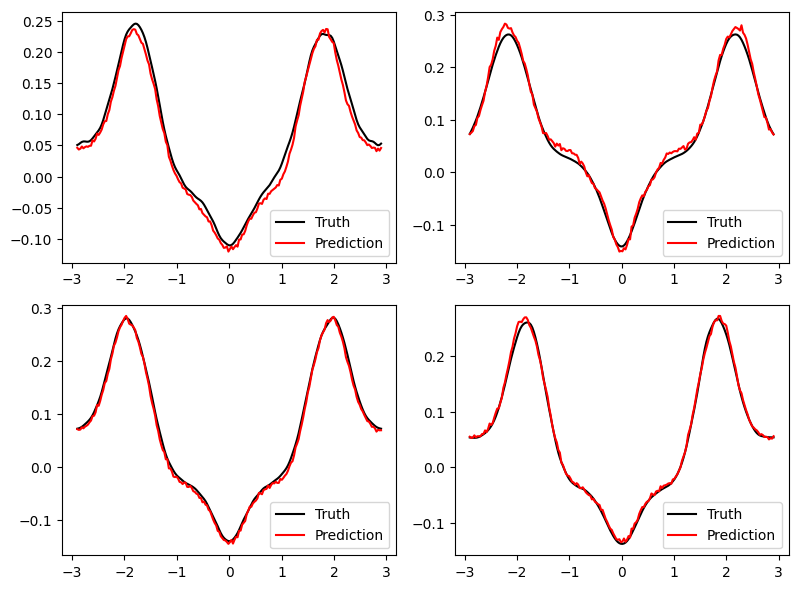

In [130]:
# Compare predictions to truth for five randomly chosen test cases
random_test_indices = rng.integers(low=0, high=N_test, size=4)
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()
for counter, idx in enumerate(random_test_indices):
    axs[counter].plot(
        uniform_x_range,
        test_output.values[idx],
        color="k",
        linestyle="-",
        label="Truth",
    )
    axs[counter].plot(
        uniform_x_range, predictions[idx], color="r", linestyle="-", label="Prediction"
    )
    axs[counter].legend(loc="lower right")
fig.set_figheight(6)
fig.set_figwidth(8)
plt.tight_layout()
plt.show()

In [94]:
# # Predict on noisy versions of input 

# # Compare predictions to truth for five randomly chosen test cases
# predictions = model.predict(test_input + 0.5*np.random.rand(*test_input.shape))
# random_test_indices = rng.integers(low=0, high=N_test, size=6)
# for idx in random_test_indices:
#     fig, ax = plt.subplots()
#     ax.plot(
#         uniform_x_range,
#         test_output.values[idx],
#         color="k",
#         linestyle="-",
#         label="Truth",
#     )
#     ax.plot(
#         uniform_x_range, predictions[idx], color="r", linestyle="-", label="Prediction"
#     )
#     plt.legend(loc="upper right")
#     plt.tight_layout()
#     plt.show()

To improve the performance of the neural network, we optimize the hyperparameters using a grid search over feasible hyperparameters:  
The number of layers, neurons in each layer, activation function, optimizer, learning rate, batch size, and epochs. 

In [95]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
X, y = make_moons()
calibrated_forest = CalibratedClassifierCV(
   estimator=RandomForestClassifier(n_estimators=10))
param_grid = {
   'estimator__max_depth': [2, 4, 6, 8]}
search = RandomizedSearchCV(calibrated_forest, param_grid, cv=5)
search.fit(X, y)

# Dropout

/Users/even/Library/Caches/pypoetry/virtualenvs/nmrlipids-emHCjlKO-py3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=CalibratedClassifierCV(estimator=RandomForestClassifier(n_estimators=10)),
                   param_distributions={'estimator__max_depth': [2, 4, 6, 8]})